# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Исследование данных

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В нашем распоряжении 7591 фотография, каждей фотографии соответствует конкретный file_name, а также real_age

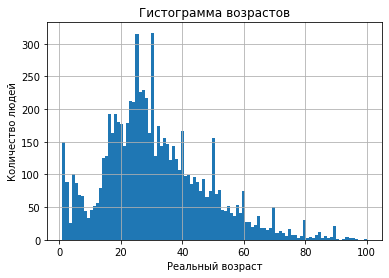

In [4]:
data.hist(bins=100)
plt.xlabel('Реальный возраст')
plt.ylabel('Количество людей')
plt.title('Гистограмма возрастов')
plt.show()

In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Средний возраст - 31.2. Большая часть возрастов расположена в диапазоне от 20 до 40 лет

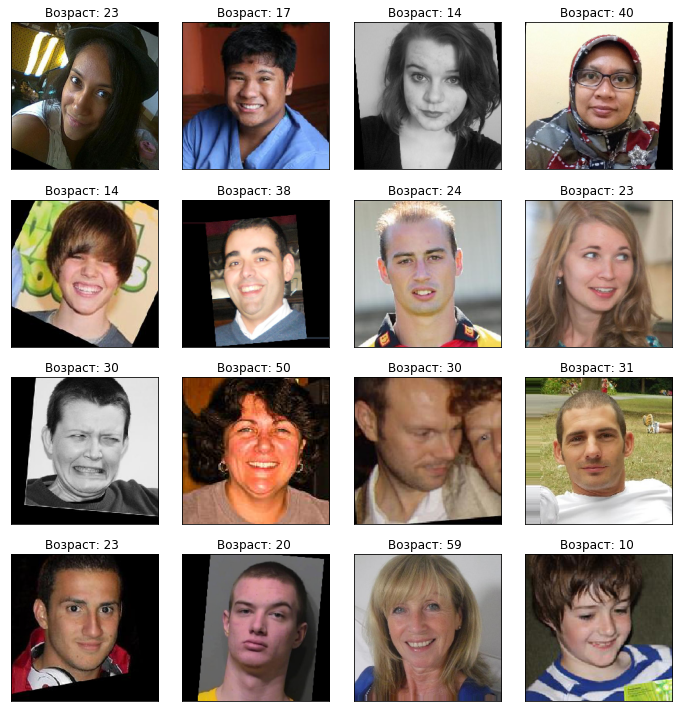

In [9]:
features, target = next(gen_flow)

fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Возраст: {target[i]} ") 
    plt.tight_layout()

Заметно различие в качестве фотографий. Различия заключаются в:
1. Насыщенности и степени освещённости
2. Ориентации фотографии
3. Положении лица в кадре
4. Наличии дополнительных предметов в кадре
5. Фотографии могут быть цветными или чёрно-белыми

### Промежуточные выводы

1. В нашем распоряжении 7591 фотография, каждей фотографии соответствует конкретный file_name, а также real_age
2. Средний возраст - 31.2. Большая часть возрастов расположена в диапазоне от 20 до 40 лет
3. Скорей всего нейросеть, обученная на этих данных будет лучше всего определять возраст в районе 20-40 лет, т.к. количество фотографий с возрастом этого диапазона сильно выше, относительно другого возраста.
4. Заметно различие в качестве фотографий. Различия заключаются в:
    1. Насыщенности и степени освещённости
    2. Ориентации фотографии
    3. Положении лица в кадре
    4. Наличии дополнительных предметов в кадре
    5. Фотографии могут быть цветными или чёрно-белыми


Данные изучены можно приступать к следующему этапу

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

### Код модели

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    labels = pd.read_csv(path + 'labels.csv')
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    labels = pd.read_csv(path + 'labels.csv')
    val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model


```

### Результаты обучения модели

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 51s - loss: 234.1528 - mean_absolute_error: 11.0465 - val_loss: 822.7515 - val_mean_absolute_error: 23.7775
Epoch 2/5
178/178 - 42s - loss: 61.1243 - mean_absolute_error: 5.9522 - val_loss: 559.5986 - val_mean_absolute_error: 18.4872
Epoch 3/5
178/178 - 45s - loss: 31.1522 - mean_absolute_error: 4.2881 - val_loss: 307.0703 - val_mean_absolute_error: 13.1033
Epoch 4/5
178/178 - 60s - loss: 19.5944 - mean_absolute_error: 3.3938 - val_loss: 117.7950 - val_mean_absolute_error: 8.3337
Epoch 5/5
178/178 - 65s - loss: 15.6043 - mean_absolute_error: 3.0318 - val_loss: 78.4878 - val_mean_absolute_error: 6.7811

60/60 - 11s - loss: 78.4878 - mean_absolute_error: 6.7811
Test MAE: 6.7811

```

## Анализ обученной модели

1. В проекте была использованна модель сверточной нейронной сети на ResNet50 предобученной на наборе изображений ImageNet. 
2. На тренировочной выборке удалось достичь значение MAE в 3.0318. 
   
   Параметры модели были следующие:
                
       1. Epoch = 5, batch size = 32
       2. Оптимизатор: Adam с learning rate 1e-4
       3. Дополнительный слой GlobalAveragePooling2D
       4. Функция потерь: MSE, Метрика: MAE
       
3. Модель прошла тестирование набрав MAE: 6.7811 на тестовых данных

## Вывод

В данном проекте мы построили модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении был набор фотографий людей с указанием возраста. Удалось достичь погрешности в 6 лет на тестовых данных.

Проект был разделён на несколько этапов. Были сделаны следующие выводы:

1. Исследовательский анализ данных

    1. В нашем распоряжении 7591 фотография, каждей фотографии соответствует конкретный file_name, а также real_age
    2. Средний возраст - 31.2. Большая часть возрастов расположена в диапазоне от 20 до 40 лет
    3. Скорей всего нейросеть, обученная на этих данных будет лучше всего определять возраст в районе 20-40 лет, т.к. количество фотографий с возрастом этого диапазона сильно выше, относительно другого возраста.
    4. Заметно различие в качестве фотографий. Различия заключаются в:
        1. Насыщенности и степени освещённости
        2. Ориентации фотографии
        3. Положении лица в кадре
        4. Наличии дополнительных предметов в кадре
        5. Фотографии могут быть цветными или чёрно-белыми
2. Обучение модели и анализ обученной модели
    1. В проекте была использованна модель сверточной нейронной сети на ResNet50 предобученной на наборе изображений ImageNet. 
    2. На тренировочной выборке удалось достичь значение MAE в 3.0318. 

       Параметры модели были следующие:

           1. Epoch = 5, batch size = 32
           2. Оптимизатор: Adam с learning rate 1e-4
           3. Дополнительный слой GlobalAveragePooling2D
           4. Функция потерь: MSE, Метрика: MAE

    3. Модель прошла тестирование набрав MAE: 6.7811 на тестовых данных
    
    
! Решение задачи поставленной бизнесом:


- [x]  Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы - Да, данная модель поможет в решении этой задачи, погрешность модели в определении возраста не столь высока для данной задачи


- [ ]  Контролировать добросовестность кассиров при продаже алкоголя - Скорей нет, для такой задачи потребовалось бы максимальное точное определение возраста, с погрешностью буквально стремящейся к 0, т.к. в данном случае чаще всего значения будут пограничным. 
